Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [1081]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [1082]:
data = pd.read_csv('aac_shelter_outcomes.csv')

In [1083]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [1084]:
data.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,78248,78256,78256,78256,78256,78256,78256,78256,54370,35963,78244,78254
unique,46,70855,5,2128,525,5869,64361,64361,14574,19,9,5
top,1 year,A706536,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14355,11,44242,23335,8153,112,39,39,344,19660,33112,27784


### Попробуем понять, что значит каждый столбец
Для помощи использовала https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes?select=aac_outcomes.csv

In [1085]:
data.columns

Index(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome'],
      dtype='object')

* 'age_upon_outcome' - возраст животного на момент принятия решения
* 'animal_id' - id животного
* 'animal_type' - тип животного (Собка/кошка/птица/домашний скот (Livestock)/другое)
* 'breed' - порода
* 'color' - цвет животного
* 'date_of_birth' - дата рождения животного
* 'datetime' - timestamp, когда по животному было принято решение outcome_type
* 'monthyear'-  месяц и год в формате timestamp от datetime
* 'name' - имя животного
* 'outcome_subtype' - более детальное описание outcome_type (где возможно)
* 'outcome_type'- решение о судьбе животного 
* 'sex_upon_outcome' - пол животного + факт стерилизации

In [1086]:
data.sex_upon_outcome.value_counts()

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
Name: sex_upon_outcome, dtype: int64

### Теперь расшифруем столбец с целевыми значениями (outcome_type)

In [1087]:
data.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

* Adoption           - животное забрали из приюта домой
* Transfer           - животное было перемещено в место, где его приютят (в сарай)
* Return to Owner    - животное возвращено владельцу
* Euthanasia         - животное усыпили
* Died               - животное умерло
* Disposal           - удаление животного (???)
* Rto-Adopt          - rto - return-to-owner (непонятно, в чем разница с Return to Owner)
* Missing            - животное пропало
* Relocate           - животное переместили

### Начнем с пропусков

In [1088]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78248 non-null  object
 1   animal_id         78256 non-null  object
 2   animal_type       78256 non-null  object
 3   breed             78256 non-null  object
 4   color             78256 non-null  object
 5   date_of_birth     78256 non-null  object
 6   datetime          78256 non-null  object
 7   monthyear         78256 non-null  object
 8   name              54370 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78254 non-null  object
dtypes: object(12)
memory usage: 7.2+ MB


In [1089]:
cols_with_empy_values = ['age_upon_outcome', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']

В перечень столбцов с пустыми значениями попал сам таргет - outcome_type. Таких строчек немного, сразу удалю их и посмотрю на оставшиеся пустые значения

In [1090]:
# data[data.outcome_type.isna()]
data = data[data.outcome_type.notna()]

In [1091]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78238 non-null  object
 1   animal_id         78244 non-null  object
 2   animal_type       78244 non-null  object
 3   breed             78244 non-null  object
 4   color             78244 non-null  object
 5   date_of_birth     78244 non-null  object
 6   datetime          78244 non-null  object
 7   monthyear         78244 non-null  object
 8   name              54363 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78243 non-null  object
dtypes: object(12)
memory usage: 7.8+ MB


Теперь посмотрим на sex_upon_outcome (осталось всего одно значение с пустотой)

In [1092]:
data[data.sex_upon_outcome.isna()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
16300,7 years,A667395,Dog,Dachshund,Brown Merle,2006-11-17T00:00:00,2013-11-27T16:11:00,2013-11-27T16:11:00,Diego,NaN,Return to Owner,NaN


In [1093]:
data.sex_upon_outcome.value_counts()

Neutered Male    27783
Spayed Female    25203
Intact Male       9547
Intact Female     9140
Unknown           6570
Name: sex_upon_outcome, dtype: int64

В данных еесть нормальное значение для обозначения неизвестного пола (Unknown) и их достаточно много, поэтому просто заменим null на Unknown 

In [1094]:
data['sex_upon_outcome'] = data.sex_upon_outcome.apply(lambda x: 'Unknown' if pd.isnull(x) else x)

In [1095]:
data.sex_upon_outcome.value_counts()

Neutered Male    27783
Spayed Female    25203
Intact Male       9547
Intact Female     9140
Unknown           6571
Name: sex_upon_outcome, dtype: int64

In [1096]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78238 non-null  object
 1   animal_id         78244 non-null  object
 2   animal_type       78244 non-null  object
 3   breed             78244 non-null  object
 4   color             78244 non-null  object
 5   date_of_birth     78244 non-null  object
 6   datetime          78244 non-null  object
 7   monthyear         78244 non-null  object
 8   name              54363 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78244 non-null  object
dtypes: object(12)
memory usage: 7.8+ MB


Теперь посмотрим на возраст age_upon_outcome

In [1097]:
data[data.age_upon_outcome.isna()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
77976,NaN,A765547,Bird,Leghorn Mix,White/Red,2017-01-22T00:00:00,2018-01-25T13:23:00,2018-01-25T13:23:00,NaN,Partner,Transfer,Intact Female
78081,NaN,A765899,Dog,Miniature Poodle Mix,Black,2011-01-29T00:00:00,2018-01-29T15:49:00,2018-01-29T15:49:00,NaN,Suffering,Euthanasia,Neutered Male
78114,NaN,A765914,Cat,Domestic Shorthair Mix,Lynx Point,2017-01-29T00:00:00,2018-01-29T18:08:00,2018-01-29T18:08:00,NaN,Suffering,Euthanasia,Intact Male
78162,NaN,A765901,Dog,Maltese Mix,Buff,2017-01-29T00:00:00,2018-01-31T08:14:00,2018-01-31T08:14:00,NaN,Partner,Transfer,Intact Male
78208,NaN,A765960,Dog,Beagle/Catahoula,Tan/White,2010-02-01T00:00:00,2018-02-01T09:21:00,2018-02-01T09:21:00,NaN,Suffering,Euthanasia,Intact Male
78253,NaN,A766098,Other,Bat Mix,Brown,2017-02-01T00:00:00,2018-02-01T18:08:00,2018-02-01T18:08:00,NaN,Rabies Risk,Euthanasia,Unknown


Тут возраст можно посчитать самим - везде есть дата рождения животного и дата outcome - посчитаем разницу + проверим, что в непустых значениях такая же логика:

In [1098]:
data.age_upon_outcome.value_counts()

1 year       14352
2 years      11194
2 months      9213
3 years       5157
3 months      3442
1 month       3341
4 years       2990
5 years       2691
4 months      2425
5 months      1951
6 months      1897
6 years       1810
8 years       1554
7 years       1537
3 weeks       1467
2 weeks       1330
10 months     1203
4 weeks       1193
8 months      1178
10 years      1158
7 months       963
9 years        822
9 months       673
12 years       609
1 weeks        513
11 months      490
11 years       429
1 week         427
13 years       389
14 years       253
3 days         235
2 days         217
15 years       208
1 day          153
6 days         152
4 days         136
5 days         116
16 years       101
0 years         94
5 weeks         61
17 years        58
18 years        26
19 years        13
20 years        12
22 years         4
25 years         1
Name: age_upon_outcome, dtype: int64

Видно, что много разных мер - дни, года, недели и т.д. План такой - разделим этот столбец на число и меру (день/неделя и т.д), затем создадим третий столбец, где число будет приведено к одной мере (скорее всего к дням, т.е. это минимальная ед измерения)

In [1099]:
data.age_upon_outcome.str.split(' ', 1)

0         [2, weeks]
1          [1, year]
2          [1, year]
3         [9, years]
4        [5, months]
            ...     
78251     [1, month]
78252     [3, years]
78253            NaN
78254    [2, months]
78255    [2, months]
Name: age_upon_outcome, Length: 78244, dtype: object

In [1100]:
data['age_dig'], data['age_metric'] = data['age_upon_outcome'].str.split(' ').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [1101]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_dig,age_metric
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,2,weeks
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1,year
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,year
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,9,years
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,5,months


In [1102]:
data[data.age_dig.isna()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_dig,age_metric
77976,NaN,A765547,Bird,Leghorn Mix,White/Red,2017-01-22T00:00:00,2018-01-25T13:23:00,2018-01-25T13:23:00,NaN,Partner,Transfer,Intact Female,NaN,NaN
78081,NaN,A765899,Dog,Miniature Poodle Mix,Black,2011-01-29T00:00:00,2018-01-29T15:49:00,2018-01-29T15:49:00,NaN,Suffering,Euthanasia,Neutered Male,NaN,NaN
78114,NaN,A765914,Cat,Domestic Shorthair Mix,Lynx Point,2017-01-29T00:00:00,2018-01-29T18:08:00,2018-01-29T18:08:00,NaN,Suffering,Euthanasia,Intact Male,NaN,NaN
78162,NaN,A765901,Dog,Maltese Mix,Buff,2017-01-29T00:00:00,2018-01-31T08:14:00,2018-01-31T08:14:00,NaN,Partner,Transfer,Intact Male,NaN,NaN
78208,NaN,A765960,Dog,Beagle/Catahoula,Tan/White,2010-02-01T00:00:00,2018-02-01T09:21:00,2018-02-01T09:21:00,NaN,Suffering,Euthanasia,Intact Male,NaN,NaN
78253,NaN,A766098,Other,Bat Mix,Brown,2017-02-01T00:00:00,2018-02-01T18:08:00,2018-02-01T18:08:00,NaN,Rabies Risk,Euthanasia,Unknown,NaN,NaN


In [1103]:
data.age_metric.value_counts()

years     31110
months    23435
year      14352
weeks      4564
month      3341
days        856
week        427
day         153
Name: age_metric, dtype: int64

In [1104]:
def convert_age_to_days_with_metric(row):
    if row['age_metric'] == 'year' or row['age_metric'] == 'years':
        return row['age_dig'] * 365
    elif row['age_metric'] == 'month' or row['age_metric'] == 'months':
        return row['age_dig'] * 30
    elif row['age_metric'] == 'week' or row['age_metric'] == 'weeks':
        return row['age_dig'] * 7
    elif row['age_metric'] == 'day' or row['age_metric'] == 'days':
        return row['age_dig'] * 1
    else:
        return np.NaN

In [1105]:
data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  78238 non-null  object
 1   animal_id         78244 non-null  object
 2   animal_type       78244 non-null  object
 3   breed             78244 non-null  object
 4   color             78244 non-null  object
 5   date_of_birth     78244 non-null  object
 6   datetime          78244 non-null  object
 7   monthyear         78244 non-null  object
 8   name              54363 non-null  object
 9   outcome_subtype   35963 non-null  object
 10  outcome_type      78244 non-null  object
 11  sex_upon_outcome  78244 non-null  object
 12  age_dig           78238 non-null  object
 13  age_metric        78238 non-null  object
dtypes: object(14)
memory usage: 9.0+ MB


In [1106]:
data['age_dig'] = data.age_dig.astype('float')

In [1107]:
# data['age_convert'] = np.where(data.age_metric.str.contains('year'), data.age_dig * 365, data.age_dig)
data['age_convert'] = data.apply(convert_age_to_days_with_metric, axis=1)

In [1108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age_upon_outcome  78238 non-null  object 
 1   animal_id         78244 non-null  object 
 2   animal_type       78244 non-null  object 
 3   breed             78244 non-null  object 
 4   color             78244 non-null  object 
 5   date_of_birth     78244 non-null  object 
 6   datetime          78244 non-null  object 
 7   monthyear         78244 non-null  object 
 8   name              54363 non-null  object 
 9   outcome_subtype   35963 non-null  object 
 10  outcome_type      78244 non-null  object 
 11  sex_upon_outcome  78244 non-null  object 
 12  age_dig           78238 non-null  float64
 13  age_metric        78238 non-null  object 
 14  age_convert       78238 non-null  float64
dtypes: float64(2), object(13)
memory usage: 9.6+ MB


In [1109]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_dig,age_metric,age_convert
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,2.0,weeks,14.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1.0,year,365.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1.0,year,365.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,9.0,years,3285.0
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,5.0,months,150.0


Теперь сделаем проверку - посчитаем разницу между date_of_birth и datetime в днях и сравним с age_convert

In [1110]:
data['date_of_birth'] = pd.to_datetime(data.date_of_birth)

In [1111]:
data['datetime'] = pd.to_datetime(data.datetime)

In [1112]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_dig,age_metric,age_convert
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,2.0,weeks,14.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1.0,year,365.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1.0,year,365.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,9.0,years,3285.0
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,5.0,months,150.0


In [1113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  78238 non-null  object        
 1   animal_id         78244 non-null  object        
 2   animal_type       78244 non-null  object        
 3   breed             78244 non-null  object        
 4   color             78244 non-null  object        
 5   date_of_birth     78244 non-null  datetime64[ns]
 6   datetime          78244 non-null  datetime64[ns]
 7   monthyear         78244 non-null  object        
 8   name              54363 non-null  object        
 9   outcome_subtype   35963 non-null  object        
 10  outcome_type      78244 non-null  object        
 11  sex_upon_outcome  78244 non-null  object        
 12  age_dig           78238 non-null  float64       
 13  age_metric        78238 non-null  object        
 14  age_convert       7823

In [1114]:
data['diff_outcome_date_birth_date_in_days'] = (data.datetime - data.date_of_birth).dt.days

In [1115]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_dig,age_metric,age_convert,diff_outcome_date_birth_date_in_days
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,2.0,weeks,14.0,15
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1.0,year,365.0,366
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1.0,year,365.0,429
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,9.0,years,3285.0,3300
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,5.0,months,150.0,181


По первым 5-ти строчкам видно, что age_upon_outcome имеет более общий смысл (не точное значение), но в целом идея с расчетом разницы в датах и подставлении полученного число вместо пустых строк в age_upon_outcome подойдет, чуть позже сами разобьем на нужные нам классы.
Но в любом случае, считаю правильным свести все к одной единице измерения, поэтому убираю age_upon_outcome и временные age_dig, age_metric, age_convert

In [1116]:
data[data.age_upon_outcome.isna()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,age_dig,age_metric,age_convert,diff_outcome_date_birth_date_in_days
77976,NaN,A765547,Bird,Leghorn Mix,White/Red,2017-01-22,2018-01-25 13:23:00,2018-01-25T13:23:00,NaN,Partner,Transfer,Intact Female,NaN,NaN,NaN,368
78081,NaN,A765899,Dog,Miniature Poodle Mix,Black,2011-01-29,2018-01-29 15:49:00,2018-01-29T15:49:00,NaN,Suffering,Euthanasia,Neutered Male,NaN,NaN,NaN,2557
78114,NaN,A765914,Cat,Domestic Shorthair Mix,Lynx Point,2017-01-29,2018-01-29 18:08:00,2018-01-29T18:08:00,NaN,Suffering,Euthanasia,Intact Male,NaN,NaN,NaN,365
78162,NaN,A765901,Dog,Maltese Mix,Buff,2017-01-29,2018-01-31 08:14:00,2018-01-31T08:14:00,NaN,Partner,Transfer,Intact Male,NaN,NaN,NaN,367
78208,NaN,A765960,Dog,Beagle/Catahoula,Tan/White,2010-02-01,2018-02-01 09:21:00,2018-02-01T09:21:00,NaN,Suffering,Euthanasia,Intact Male,NaN,NaN,NaN,2922
78253,NaN,A766098,Other,Bat Mix,Brown,2017-02-01,2018-02-01 18:08:00,2018-02-01T18:08:00,NaN,Rabies Risk,Euthanasia,Unknown,NaN,NaN,NaN,365


In [1117]:
data.drop(['age_upon_outcome', 'age_dig', 'age_metric', 'age_convert'], axis=1, inplace=True)

In [1118]:
data.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,15
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,366
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,429
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,3300
4,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,181


In [1119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   animal_id                             78244 non-null  object        
 1   animal_type                           78244 non-null  object        
 2   breed                                 78244 non-null  object        
 3   color                                 78244 non-null  object        
 4   date_of_birth                         78244 non-null  datetime64[ns]
 5   datetime                              78244 non-null  datetime64[ns]
 6   monthyear                             78244 non-null  object        
 7   name                                  54363 non-null  object        
 8   outcome_subtype                       35963 non-null  object        
 9   outcome_type                          78244 non-null  object        
 10

Осталось два поля с пустыми значениями - name и outcome_subtype.
Кажется, что name не может влиять на решение о приюте животного, но пока оставим ради интереса, заменим только на какое-нибудь значение, типо Unknown
А outcome_subtype посмотрим поподробнее, но скорее всего уберем его вообще, так как значение может напрямую указывать на outcome_type

In [1120]:
data.name.value_counts()

Bella        344
Max          319
Luna         239
Rocky        236
Princess     235
            ... 
Caliman        1
Skylos         1
*Cosco         1
Mr. Fuzzy      1
Jumbly         1
Name: name, Length: 14574, dtype: int64

In [1121]:
data_with_special_name = data[(data.name.fillna(' ').str.contains('^\W', regex=True))&(data.name.notna())]

Не понятно, зачем нужен символ * перед именем животного

In [1122]:
data_with_special_name.animal_type.value_counts()

Dog      9490
Cat      8938
Other     171
Bird        7
Name: animal_type, dtype: int64

In [1123]:
data_with_special_name.outcome_type.value_counts()

Adoption           12095
Transfer            5729
Euthanasia           333
Return to Owner      281
Died                 139
Missing               23
Rto-Adopt              6
Name: outcome_type, dtype: int64

In [1124]:
data_with_special_name.outcome_subtype.value_counts()

Partner           5596
Foster            3126
Offsite            191
Suffering          149
SCRP               115
Aggressive          84
In Foster           80
In Kennel           56
Behavior            52
Medical             28
Snr                 18
Rabies Risk         12
At Vet              12
In Surgery           5
Possible Theft       4
Name: outcome_subtype, dtype: int64

In [1125]:
data_with_special_name.sex_upon_outcome.value_counts()

Neutered Male    8025
Spayed Female    7538
Intact Female    1585
Intact Male      1407
Unknown            51
Name: sex_upon_outcome, dtype: int64

Значения такие же как и в основном датасете, просто уберу эту звездочку, возможно, в приюте не знают точного имени и/или назвали сами. Но создам пока столбец с флагом - имя было со звездочкой или без

In [1126]:
data['name'] = data.name.str.replace('*', 'SPECIAL_CH_TO_REMOVE')

In [1127]:
data['is_special_name'] = np.where(data.name.str.contains('SPECIAL_CH_TO_REMOVE'), 1, 0)
data['is_special_name'] = np.where(data.name.isna(), 0, data.is_special_name)

In [1128]:
data.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,15,0
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,366,0
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,SPECIAL_CH_TO_REMOVEJohnny,NaN,Adoption,Neutered Male,429,1
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,3300,0
4,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,181,0


In [1129]:
data['name'] = data.name.str.replace('SPECIAL_CH_TO_REMOVE', '')

In [1130]:
data.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,15,0
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,366,0
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,Johnny,NaN,Adoption,Neutered Male,429,1
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,3300,0
4,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,181,0


Создам еще столбец - из скольких слов состоит имя животного, если пустота - 0

In [1131]:
data['name_num_of_words'] = data.name.str.split(' ').str.len().fillna(0).astype('int')

In [1132]:
data.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,15,0,0
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,366,0,1
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,Johnny,NaN,Adoption,Neutered Male,429,1,1
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,3300,0,1
4,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,181,0,0


In [1133]:
data.name_num_of_words.value_counts()

1    52127
0    23881
2     2198
3       30
4        8
Name: name_num_of_words, dtype: int64

In [1134]:
data['name'] = data.name.fillna('No name')

In [1135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   animal_id                             78244 non-null  object        
 1   animal_type                           78244 non-null  object        
 2   breed                                 78244 non-null  object        
 3   color                                 78244 non-null  object        
 4   date_of_birth                         78244 non-null  datetime64[ns]
 5   datetime                              78244 non-null  datetime64[ns]
 6   monthyear                             78244 non-null  object        
 7   name                                  78244 non-null  object        
 8   outcome_subtype                       35963 non-null  object        
 9   outcome_type                          78244 non-null  object        
 10

Теперь посмотрим зависмость outcome_subtype и outcome_type

In [1136]:
data.groupby('outcome_subtype')['outcome_type'].nunique()

outcome_subtype
Aggressive             1
At Vet                 2
Barn                   2
Behavior               1
Court/Investigation    1
Enroute                1
Foster                 1
In Foster              2
In Kennel              2
In Surgery             1
Medical                1
Offsite                1
Partner                1
Possible Theft         1
Rabies Risk            1
SCRP                   1
Snr                    1
Suffering              1
Underage               1
Name: outcome_type, dtype: int64

Чаще всего outcome_subtype указывает на конкретный outcome_type (кол-во уникальных outcome_type = 1), но есть несколько случаев с несколькими outcome_type:

In [1137]:
data[data.outcome_subtype.isin(['At Vet', 'Barn', 'In Foster', 'In Kennel'])]\
.groupby(['outcome_subtype', 'outcome_type'])['animal_id'].count()

outcome_subtype  outcome_type
At Vet           Died             33
                 Euthanasia       26
Barn             Adoption          1
                 Transfer          2
In Foster        Died            164
                 Missing          18
In Kennel        Died            335
                 Missing           8
Name: animal_id, dtype: int64

На мой взгляд, нужно убирать этот столбец, так как даже в значениях, на которые приходится по несколько outcome_type, видно что эти значения, в целом, одной группы (Died и Euthanasia, например).

In [1138]:
data.drop(['outcome_subtype'], axis=1, inplace=True)

In [1139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   animal_id                             78244 non-null  object        
 1   animal_type                           78244 non-null  object        
 2   breed                                 78244 non-null  object        
 3   color                                 78244 non-null  object        
 4   date_of_birth                         78244 non-null  datetime64[ns]
 5   datetime                              78244 non-null  datetime64[ns]
 6   monthyear                             78244 non-null  object        
 7   name                                  78244 non-null  object        
 8   outcome_type                          78244 non-null  object        
 9   sex_upon_outcome                      78244 non-null  object        
 10

Почистили все пустые значения и заодно сделали некоторые преобразования.

In [1140]:
data.head()

,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words
0,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,No name,Transfer,Intact Male,15,0,0
1,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Transfer,Spayed Female,366,0,1
2,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,Johnny,Adoption,Neutered Male,429,1,1
3,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Transfer,Neutered Male,3300,0,1
4,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,No name,Euthanasia,Unknown,181,0,0


In [1141]:
data.describe(include='all')

,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words
count,78244,78244,78244,78244,78244,78244,78244,78244,78244,78244,78244.000000,78244.000000,78244.000000
unique,70848,5,2128,525,5869,64352,64352,11791,9,5,NaN,NaN,NaN
top,A706536,Dog,Domestic Shorthair Mix,Black/White,2014-05-05 00:00:00,2016-04-18 00:00:00,2016-04-18T00:00:00,No name,Adoption,Neutered Male,NaN,NaN,NaN
freq,11,44238,23332,8151,112,39,39,23881,33112,27783,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,1991-12-11 00:00:00,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2017-12-25 00:00:00,2018-02-01 18:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,817.072939,0.237820,0.723953
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1077.104918,0.425751,0.509469
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.000000,0.000000,0.000000


Что мне не нравится:
* animal_id - не несет информации, уберу совсем
* breed - очень много уникальных значений, нужно попробовать сгруппировать
* color - тоже многова-то значений
* date_of_birth - у нас уже есть возраст животного, кажется излишним еще дату анализировать, вряд ли для будущего хозяина имеет значения знак зодиака животного
* datetime - очень детально, можно оставить monthyear
* monthyear - плохой формат, вообще непонятно читается, надо привести в порядок
* name - уже говорила, что скорее всего уберу, но пока пусть будет
* sex_upon_outcome - тут два фактора в одном столбце (пол + стерилизован), создам два отдельных - пол и факт стерилизации, но этот тоже оставлю
* diff_outcome_date_birth_date_in_days - нужно будет создать группы (например, от 0 до 90, от 90 до 180, от 180 до 365 и т.д.)
* редко встречаются НЕ кошки и собаки в animal_type


In [1142]:
data.drop(['animal_id'], axis=1, inplace=True)

еще сделам pandas_profiling, чтобы проверить зависимости

In [1143]:
data.profile_report()

pandas_profiling подтвердил наши опасения по поводу большого кол-ва уникальных значений, показал, что есть корреляция между outcome_type и animal_type (логично, собачек и кошек берут больше)

In [1144]:
data.head()

,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words
0,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22T16:04:00,No name,Transfer,Intact Male,15,0,0
1,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07T11:47:00,Lucy,Transfer,Spayed Female,366,0,1
2,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03T14:20:00,Johnny,Adoption,Neutered Male,429,1,1
3,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15T15:50:00,Monday,Transfer,Neutered Male,3300,0,1
4,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,2014-07-07T14:04:00,No name,Euthanasia,Unknown,181,0,0


In [1145]:
data['monthyear'] = pd.to_datetime(data.monthyear).dt.strftime('%Y-%m')

In [1146]:
data.describe(include='all')

,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words
count,78244,78244,78244,78244,78244,78244,78244,78244,78244,78244.000000,78244.000000,78244.000000
unique,5,2128,525,5869,64352,53,11791,9,5,NaN,NaN,NaN
top,Dog,Domestic Shorthair Mix,Black/White,2014-05-05 00:00:00,2016-04-18 00:00:00,2014-07,No name,Adoption,Neutered Male,NaN,NaN,NaN
freq,44238,23332,8151,112,39,2084,23881,33112,27783,NaN,NaN,NaN
first,NaN,NaN,NaN,1991-12-11 00:00:00,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2017-12-25 00:00:00,2018-02-01 18:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,817.072939,0.237820,0.723953
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1077.104918,0.425751,0.509469
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.000000,0.000000,0.000000


Теперь можно убрать datetime и date_of_birth

In [1147]:
data.drop(['datetime', 'date_of_birth'], axis=1, inplace=True)

In [1148]:
data.head()

,animal_type,breed,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words
0,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07,No name,Transfer,Intact Male,15,0,0
1,Dog,Beagle Mix,White/Brown,2013-11,Lucy,Transfer,Spayed Female,366,0,1
2,Dog,Pit Bull,Blue/White,2014-06,Johnny,Adoption,Neutered Male,429,1,1
3,Dog,Miniature Schnauzer Mix,White,2014-06,Monday,Transfer,Neutered Male,3300,0,1
4,Other,Bat Mix,Brown,2014-07,No name,Euthanasia,Unknown,181,0,0


In [1149]:
data.sex_upon_outcome.value_counts()

Neutered Male    27783
Spayed Female    25203
Intact Male       9547
Intact Female     9140
Unknown           6571
Name: sex_upon_outcome, dtype: int64

In [1150]:
data['sterilized'], data['gender'] = data['sex_upon_outcome'].str.split(' ').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [1151]:
data.sterilized.value_counts()

Neutered    27783
Spayed      25203
Intact      18687
Unknown      6571
Name: sterilized, dtype: int64

In [1152]:
data.gender.value_counts()

Male      37330
Female    34343
Name: gender, dtype: int64

In [1153]:
data[data.sex_upon_outcome == 'Unknown']

,animal_type,breed,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender
4,Other,Bat Mix,Brown,2014-07,No name,Euthanasia,Unknown,181,0,0,Unknown,NaN
6,Other,Squirrel Mix,Tan,2014-12,No name,Euthanasia,Unknown,365,0,0,Unknown,NaN
20,Cat,Domestic Shorthair Mix,Brown Tabby/White,2014-03,No name,Transfer,Unknown,244,0,0,Unknown,NaN
30,Cat,Domestic Shorthair Mix,Black,2014-06,No name,Transfer,Unknown,15,0,0,Unknown,NaN
40,Other,Bat,Black/Brown,2014-07,No name,Euthanasia,Unknown,366,0,0,Unknown,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
78200,Cat,Domestic Shorthair Mix,White/Black,2018-01,No name,Transfer,Unknown,1098,0,0,Unknown,NaN
78206,Bird,Pheasant Mix,Gold/Brown,2018-01,No name,Transfer,Unknown,734,0,0,Unknown,NaN
78219,Other,Raccoon Mix,Black/Gray,2018-02,No name,Euthanasia,Unknown,731,0,0,Unknown,NaN
78220,Other,Raccoon Mix,Black/Gray,2018-02,No name,Euthanasia,Unknown,731,0,0,Unknown,NaN


In [1154]:
data['gender'] = data.gender.fillna('No gender info')

In [1155]:
data.gender.value_counts()

Male              37330
Female            34343
No gender info     6571
Name: gender, dtype: int64

In [1156]:
data['sterilized'] = data.sterilized.apply(lambda x: x if x!='Unknown' else 'No steril info')

In [1157]:
data.sterilized.value_counts()

Neutered          27783
Spayed            25203
Intact            18687
No steril info     6571
Name: sterilized, dtype: int64

Заметила, что Neutered и Spayed это по сути одно и тоже, просто одно для мальчиков, другое для девочек - объединим это в один признак -  sterilized


In [1158]:
data['sterilized'] = data.sterilized.apply(lambda x: 'Sterilized' if x == 'Neutered' or x == 'Spayed'\
                                           else x)

In [1159]:
data.sterilized.value_counts()

Sterilized        52986
Intact            18687
No steril info     6571
Name: sterilized, dtype: int64

In [1160]:
data.sex_upon_outcome.value_counts()

Neutered Male    27783
Spayed Female    25203
Intact Male       9547
Intact Female     9140
Unknown           6571
Name: sex_upon_outcome, dtype: int64

Тут мне не нравится Unknown - заменю на более говорящее понятие, например No gender/steril info

In [1161]:
data['sex_upon_outcome'] = data.sex_upon_outcome.apply(lambda x: 'No gender/steril info' if x == 'Unknown'\
                                                      else x)

In [1162]:
data.sex_upon_outcome.value_counts()

Neutered Male            27783
Spayed Female            25203
Intact Male               9547
Intact Female             9140
No gender/steril info     6571
Name: sex_upon_outcome, dtype: int64

In [1163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   animal_type                           78244 non-null  object
 1   breed                                 78244 non-null  object
 2   color                                 78244 non-null  object
 3   monthyear                             78244 non-null  object
 4   name                                  78244 non-null  object
 5   outcome_type                          78244 non-null  object
 6   sex_upon_outcome                      78244 non-null  object
 7   diff_outcome_date_birth_date_in_days  78244 non-null  int64 
 8   is_special_name                       78244 non-null  int64 
 9   name_num_of_words                     78244 non-null  int64 
 10  sterilized                            78244 non-null  object
 11  gender                      

In [1164]:
data.describe(include='all')

,animal_type,breed,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender
count,78244,78244,78244,78244,78244,78244,78244,78244.000000,78244.000000,78244.000000,78244,78244
unique,5,2128,525,53,11791,9,5,NaN,NaN,NaN,3,3
top,Dog,Domestic Shorthair Mix,Black/White,2014-07,No name,Adoption,Neutered Male,NaN,NaN,NaN,Sterilized,Male
freq,44238,23332,8151,2084,23881,33112,27783,NaN,NaN,NaN,52986,37330
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,817.072939,0.237820,0.723953,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1077.104918,0.425751,0.509469,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.000000,0.000000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1096.000000,0.000000,1.000000,NaN,NaN


In [1165]:
data.breed.value_counts()

Domestic Shorthair Mix            23332
Pit Bull Mix                       6133
Chihuahua Shorthair Mix            4733
Labrador Retriever Mix             4607
Domestic Medium Hair Mix           2323
                                  ...  
Great Dane/Australian Shepherd        1
Pekingese/Maltese                     1
Mastiff/Bloodhound                    1
Carolina Dog/Border Collie            1
Airedale Terrier                      1
Name: breed, Length: 2128, dtype: int64

In [1166]:
data.breed.str.replace(' Mix', '').value_counts()

Domestic Shorthair                  23718
Pit Bull                             6367
Chihuahua Shorthair                  4933
Labrador Retriever                   4837
Domestic Medium Hair                 2454
                                    ...  
Dutch Shepherd/Anatol Shepherd          1
Great Dane/Australian Shepherd          1
Mastiff/Bloodhound                      1
Carolina Dog/Border Collie              1
Pit Bull/St. Bernard Smooth Coat        1
Name: breed, Length: 1917, dtype: int64

In [1167]:
data.breed.str.replace(' Mix', '').str.split(' ')

0                          [Domestic, Shorthair]
1                                       [Beagle]
2                                    [Pit, Bull]
3                         [Miniature, Schnauzer]
4                                          [Bat]
                          ...                   
78251    [Golden, Retriever/Labrador, Retriever]
78252                                  [Mastiff]
78253                                      [Bat]
78254                      [Standard, Schnauzer]
78255                      [Labrador, Retriever]
Name: breed, Length: 78244, dtype: object

Уберем MIX

In [1168]:
data['breed'] = data.breed.str.replace(' Mix', '')

In [1169]:
data.breed.str.count(' ').sort_values()

67057    0
30472    0
65824    0
48703    0
12776    0
        ..
8094     5
26990    5
20664    5
6329     6
13576    6
Name: breed, Length: 78244, dtype: int64

In [1170]:
data[data.index == 13576].breed.unique()

array(['American Pit Bull Terrier/American Pit Bull Terrier'],
      dtype=object)

In [1171]:
data.breed.str.count('/').sort_values()

0        0
51141    0
51140    0
51139    0
51138    0
        ..
9367     2
11834    2
26659    2
21792    2
56824    2
Name: breed, Length: 78244, dtype: int64

In [1172]:
data['breed_1'], data['breed_2'] = data.breed.str.split('/', 1).str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [1173]:
data.breed_2.value_counts()

Labrador Retriever     931
Chihuahua Shorthair    563
Pit Bull               474
Dachshund              390
German Shepherd        357
                      ... 
Tibetan Spaniel          1
Lop-English              1
Boerboel                 1
Otterhound               1
Abyssinian               1
Name: breed_2, Length: 180, dtype: int64

In [1174]:
data[data.breed.str.contains('/')].head()

,animal_type,breed,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1,breed_2
11,Dog,Papillon/Border Collie,Black/White,2014-03,Fancy,Transfer,Neutered Male,759,0,1,Sterilized,Male,Papillon,Border Collie
12,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-05,Kash,Adoption,Neutered Male,80,0,1,Sterilized,Male,Chihuahua Shorthair,Pomeranian
13,Dog,Miniature Schnauzer/Miniature Poodle,White,2014-04,Sandy,Return to Owner,Spayed Female,1824,0,1,Sterilized,Female,Miniature Schnauzer,Miniature Poodle
18,Dog,German Shepherd/Labrador Retriever,Black/White,2014-12,Bonnie,Adoption,Spayed Female,63,1,1,Sterilized,Female,German Shepherd,Labrador Retriever
42,Dog,Cardigan Welsh Corgi/English Setter,White/Black,2014-02,Aria,Adoption,Spayed Female,96,0,1,Sterilized,Female,Cardigan Welsh Corgi,English Setter


In [1175]:
data.breed_1.str.count(' ').sort_values()

32591    0
65951    0
65946    0
65944    0
31507    0
        ..
19442    4
68074    4
25906    4
31378    4
24366    4
Name: breed_1, Length: 78244, dtype: int64

In [1176]:
data[data.index == 24366].breed.unique()

array(['Nova Scotia Duck Tolling Retriever'], dtype=object)

In [1177]:
data.breed_1.str.split(' ', -1).str[-1]

0        Shorthair
1           Beagle
2             Bull
3        Schnauzer
4              Bat
           ...    
78251    Retriever
78252      Mastiff
78253          Bat
78254    Schnauzer
78255    Retriever
Name: breed_1, Length: 78244, dtype: object

In [1178]:
data['breed_1_type'] = data.breed_1.str.split(' ', -1).str[-1]
data['breed_2_type'] = data.breed_2.str.split(' ', -1).str[-1]

In [1179]:
data.head()

,animal_type,breed,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1,breed_2,breed_1_type,breed_2_type
0,Cat,Domestic Shorthair,Orange Tabby,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Domestic Shorthair,NaN,Shorthair,NaN
1,Dog,Beagle,White/Brown,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,Female,Beagle,NaN,Beagle,NaN
2,Dog,Pit Bull,Blue/White,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,Male,Pit Bull,NaN,Bull,NaN
3,Dog,Miniature Schnauzer,White,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Miniature Schnauzer,NaN,Schnauzer,NaN
4,Other,Bat,Brown,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,NaN,Bat,NaN


In [1180]:
data.breed_1_type.value_counts()

Shorthair          29580
Bull                6736
Retriever           6402
Terrier             3754
Shepherd            3518
                   ...  
Hedgehog               1
Angora-French          1
Chinchilla-Amer        1
Ringtail               1
Elkhound               1
Name: breed_1_type, Length: 241, dtype: int64

Итак, мы разбили породы на 2 столбца (2 будет заполнен, если порода смешанная). Для 1 столбца (основного), мы выделили "семейство", итого получилось 241 уникальное значение. Уберем столбец breed, breed_1, breed_2, breed_2_type. Вместо этого у нас останется breed_1_type, а также сделаем доп.столбец с флагом - смешанная порода или нет.

In [1181]:
data['is_mixed_breed'] = data.breed_2.apply(lambda x: 1 if pd.notna(x) else 0)

In [1182]:
data[data.breed.str.contains('/')].head()

,animal_type,breed,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1,breed_2,breed_1_type,breed_2_type,is_mixed_breed
11,Dog,Papillon/Border Collie,Black/White,2014-03,Fancy,Transfer,Neutered Male,759,0,1,Sterilized,Male,Papillon,Border Collie,Papillon,Collie,1
12,Dog,Chihuahua Shorthair/Pomeranian,Black,2014-05,Kash,Adoption,Neutered Male,80,0,1,Sterilized,Male,Chihuahua Shorthair,Pomeranian,Shorthair,Pomeranian,1
13,Dog,Miniature Schnauzer/Miniature Poodle,White,2014-04,Sandy,Return to Owner,Spayed Female,1824,0,1,Sterilized,Female,Miniature Schnauzer,Miniature Poodle,Schnauzer,Poodle,1
18,Dog,German Shepherd/Labrador Retriever,Black/White,2014-12,Bonnie,Adoption,Spayed Female,63,1,1,Sterilized,Female,German Shepherd,Labrador Retriever,Shepherd,Retriever,1
42,Dog,Cardigan Welsh Corgi/English Setter,White/Black,2014-02,Aria,Adoption,Spayed Female,96,0,1,Sterilized,Female,Cardigan Welsh Corgi,English Setter,Corgi,Setter,1


In [1183]:
data.drop(['breed', 'breed_1', 'breed_2', 'breed_2_type'], axis=1, inplace=True)

In [1184]:
data.head()

,animal_type,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed
0,Cat,Orange Tabby,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Shorthair,0
1,Dog,White/Brown,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,Female,Beagle,0
2,Dog,Blue/White,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,Male,Bull,0
3,Dog,White,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Schnauzer,0
4,Other,Brown,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,0


In [1185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   animal_type                           78244 non-null  object
 1   color                                 78244 non-null  object
 2   monthyear                             78244 non-null  object
 3   name                                  78244 non-null  object
 4   outcome_type                          78244 non-null  object
 5   sex_upon_outcome                      78244 non-null  object
 6   diff_outcome_date_birth_date_in_days  78244 non-null  int64 
 7   is_special_name                       78244 non-null  int64 
 8   name_num_of_words                     78244 non-null  int64 
 9   sterilized                            78244 non-null  object
 10  gender                                78244 non-null  object
 11  breed_1_type                

In [1186]:
data.describe(include='all')

,animal_type,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed
count,78244,78244,78244,78244,78244,78244,78244.000000,78244.000000,78244.000000,78244,78244,78244,78244.000000
unique,5,525,53,11791,9,5,NaN,NaN,NaN,3,3,241,NaN
top,Dog,Black/White,2014-07,No name,Adoption,Neutered Male,NaN,NaN,NaN,Sterilized,Male,Shorthair,NaN
freq,44238,8151,2084,23881,33112,27783,NaN,NaN,NaN,52986,37330,29580,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,817.072939,0.237820,0.723953,NaN,NaN,NaN,0.092097
std,NaN,NaN,NaN,NaN,NaN,NaN,1077.104918,0.425751,0.509469,NaN,NaN,NaN,0.289164
min,NaN,NaN,NaN,NaN,NaN,NaN,-123.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,95.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,371.000000,0.000000,1.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,1096.000000,0.000000,1.000000,NaN,NaN,NaN,0.000000


In [1187]:
breed_stat = pd.DataFrame(data.breed_1_type.value_counts())

In [1188]:
breed_stat.describe()

,breed_1_type
count,241.000000
mean,324.663900
std,2030.203058
min,1.000000
25%,3.000000
50%,12.000000
75%,72.000000
max,29580.000000


In [1189]:
breed_stat.head()

,breed_1_type
Shorthair,29580
Bull,6736
Retriever,6402
Terrier,3754
Shepherd,3518


In [1190]:
sum(breed_stat[breed_stat.breed_1_type > 10].breed_1_type)/78244

0.9947344205306478

In [1191]:
data.shape

(78244, 13)

In [1192]:
data.animal_type.value_counts()

Dog          44238
Cat          29419
Other         4244
Bird           334
Livestock        9
Name: animal_type, dtype: int64

In [1193]:
data[data.breed_1_type.isin(breed_stat[breed_stat.breed_1_type > 8].index)].shape

(77920, 13)

In [1194]:
data[data.breed_1_type.isin(breed_stat[breed_stat.breed_1_type > 8].index)].animal_type.value_counts()

Dog          44163
Cat          29373
Other         4133
Bird           244
Livestock        7
Name: animal_type, dtype: int64

Можно убрать редкие записи (breed_1_type > 8).

In [1195]:
data = data[data.breed_1_type.isin(breed_stat[breed_stat.breed_1_type > 8].index)]
data.shape

(77920, 13)

Теперь посмотрим на цвет:

In [1196]:
data.color.value_counts()

Black/White           8135
Black                 6570
Brown Tabby           4441
Brown                 3460
White                 2750
                      ... 
Seal Point/Buff          1
Brown Tiger/Brown        1
Orange/Blue              1
Black/Seal Point         1
Chocolate/Red Tick       1
Name: color, Length: 517, dtype: int64

In [1197]:
data.color.str.count('/').sort_values()

0        0
64109    0
26282    0
64108    0
55089    0
        ..
33723    1
33725    1
33729    1
33774    1
78255    1
Name: color, Length: 77920, dtype: int64

In [1198]:
data['color_1'], data['color_2'] = data.color.str.split('/').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [1199]:
data.color_1.value_counts().head()

Black          18917
White           9856
Brown           7627
Brown Tabby     6852
Tan             5225
Name: color_1, dtype: int64

In [1200]:
data.color_2.value_counts().head()

White    24733
Black     4988
Tan       3856
Brown     3415
Gray       678
Name: color_2, dtype: int64

In [1201]:
data['color_1'], data['color_1_picture'] = data.color_1.str.split(' ', 1).str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [1202]:
data['color_2'], data['color_2_picture'] = data.color_2.str.split(' ').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [1203]:
data.head()

,animal_type,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1,color_2,color_1_picture,color_2_picture
0,Cat,Orange Tabby,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Shorthair,0,Orange,NaN,Tabby,NaN
1,Dog,White/Brown,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,Female,Beagle,0,White,Brown,NaN,NaN
2,Dog,Blue/White,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,Male,Bull,0,Blue,White,NaN,NaN
3,Dog,White,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Schnauzer,0,White,NaN,NaN,NaN
4,Other,Brown,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,0,Brown,NaN,NaN,NaN


In [1204]:
# sum(
data.color_1.value_counts()
# .head(12)
# /len(data)

Black        19585
Brown        16787
White         9856
Blue          5887
Tan           5225
Orange        3435
Red           2440
Tricolor      2089
Tortie        1538
Calico        1499
Gray          1487
Cream         1411
Chocolate     1272
Torbie        1034
Sable          783
Yellow         728
Fawn           573
Buff           552
Lynx           484
Seal           375
Silver         227
Flame          204
Gold           180
Lilac           85
Apricot         70
Liver           44
Pink            30
Green           26
Agouti          13
Ruddy            1
Name: color_1, dtype: int64

In [1205]:
color_dict = {'Black': 'Black', 'Brown':'Brown', 'White':'White', 'Blue':'Blue', 'Tan': 'Orange', 'Orange':'Orange'\
            ,'Red':'Red', 'Tricolor':'Tricolor', 'Tortie':'Green', 'Calico':'Tricolor', 'Gray':'Gray', \
            'Cream':'White','Chocolate':'Brown', 'Torbie':'Tricolor', 'Sable':'Black', 'Yellow':'Orange',\
              'Fawn':'Orange', 'Buff':'Brown', 'Lynx':'Other', 'Seal':'Other', 'Silver':'Gray','Flame': 'Orange'\
            ,'Gold':'Orange', 'Lilac':'Pink', 'Apricot':'Orange', 'Liver':'Other', 'Pink':'Pink', 'Green':'Green'\
            ,'Agouti':'Gray', 'Ruddy':'Red'}

In [1206]:
data['color_1_gr'] = data.color_1.map(color_dict)
data['color_2_gr'] = data.color_2.map(color_dict)

In [1207]:
data[(data.color_2_gr.isna())&(data.color_2.notna())]

,animal_type,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1,color_2,color_1_picture,color_2_picture,color_1_gr,color_2_gr


In [1208]:
data['is_color_with_picture'] = data.apply(lambda x: 0 if pd.isna(x['color_1_picture']) \
                                           and pd.isna(x['color_2_picture']) else 1, axis=1)

In [1209]:
data.head()

,animal_type,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1,color_2,color_1_picture,color_2_picture,color_1_gr,color_2_gr,is_color_with_picture
0,Cat,Orange Tabby,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Shorthair,0,Orange,NaN,Tabby,NaN,Orange,NaN,1
1,Dog,White/Brown,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,Female,Beagle,0,White,Brown,NaN,NaN,White,Brown,0
2,Dog,Blue/White,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,Male,Bull,0,Blue,White,NaN,NaN,Blue,White,0
3,Dog,White,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Schnauzer,0,White,NaN,NaN,NaN,White,NaN,0
4,Other,Brown,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,0,Brown,NaN,NaN,NaN,Brown,NaN,0


In [1210]:
data[data.color_2.isna()]

,animal_type,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1,color_2,color_1_picture,color_2_picture,color_1_gr,color_2_gr,is_color_with_picture
0,Cat,Orange Tabby,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Shorthair,0,Orange,NaN,Tabby,NaN,Orange,NaN,1
3,Dog,White,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Schnauzer,0,White,NaN,NaN,NaN,White,NaN,0
4,Other,Brown,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,0,Brown,NaN,NaN,NaN,Brown,NaN,0
6,Other,Tan,2014-12,No name,Euthanasia,No gender/steril info,365,0,0,No steril info,No gender info,Squirrel,0,Tan,NaN,NaN,NaN,Orange,NaN,0
7,Dog,Brown,2014-12,Ella,Transfer,Spayed Female,1111,1,1,Sterilized,Female,Shorthair,0,Brown,NaN,NaN,NaN,Brown,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78239,Dog,White,2018-02,Bailey,Adoption,Spayed Female,59,0,1,Sterilized,Female,Retriever,1,White,NaN,NaN,NaN,White,NaN,0
78243,Dog,Brown,2018-02,No name,Adoption,Neutered Male,80,0,0,Sterilized,Male,Schnauzer,0,Brown,NaN,NaN,NaN,Brown,NaN,0
78245,Dog,White,2018-02,No name,Adoption,Spayed Female,59,0,0,Sterilized,Female,Retriever,1,White,NaN,NaN,NaN,White,NaN,0
78253,Other,Brown,2018-02,No name,Euthanasia,No gender/steril info,365,0,0,No steril info,No gender info,Bat,0,Brown,NaN,NaN,NaN,Brown,NaN,0


In [1211]:
data['is_double_color'] = data.color_2.apply(lambda x: 0 if pd.isna(x) else 1)

In [1212]:
data.head()

,animal_type,color,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,...,breed_1_type,is_mixed_breed,color_1,color_2,color_1_picture,color_2_picture,color_1_gr,color_2_gr,is_color_with_picture,is_double_color
0,Cat,Orange Tabby,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,...,Shorthair,0,Orange,NaN,Tabby,NaN,Orange,NaN,1,0
1,Dog,White/Brown,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,...,Beagle,0,White,Brown,NaN,NaN,White,Brown,0,1
2,Dog,Blue/White,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,...,Bull,0,Blue,White,NaN,NaN,Blue,White,0,1
3,Dog,White,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,...,Schnauzer,0,White,NaN,NaN,NaN,White,NaN,0,0
4,Other,Brown,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,...,Bat,0,Brown,NaN,NaN,NaN,Brown,NaN,0,0


In [1213]:
data.drop(['color', 'color_1', 'color_2', 'color_1_picture', 'color_2_picture', 'color_2_gr'], axis=1, inplace=True)

In [1214]:
data.head()

,animal_type,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1_gr,is_color_with_picture,is_double_color
0,Cat,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Shorthair,0,Orange,1,0
1,Dog,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,Female,Beagle,0,White,0,1
2,Dog,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,Male,Bull,0,Blue,0,1
3,Dog,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Schnauzer,0,White,0,0
4,Other,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,0,Brown,0,0


In [1215]:
sum(data.color_1_gr.value_counts().head(6))/len(data)

0.9133726899383984

In [1216]:
list_of_top_colors = data.color_1_gr.value_counts().head(6).index
list_of_top_colors

Index(['Black', 'Brown', 'White', 'Orange', 'Blue', 'Tricolor'], dtype='object')

In [1217]:
data['color_1_gr'] = data.color_1_gr.apply(lambda x: x if x in list_of_top_colors\
                                          else 'Other color')

In [1218]:
data.head()

,animal_type,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1_gr,is_color_with_picture,is_double_color
0,Cat,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Shorthair,0,Orange,1,0
1,Dog,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,Female,Beagle,0,White,0,1
2,Dog,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,Male,Bull,0,Blue,0,1
3,Dog,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Schnauzer,0,White,0,0
4,Other,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,0,Brown,0,0


In [1219]:
data.animal_type.value_counts()

Dog          44163
Cat          29373
Other         4133
Bird           244
Livestock        7
Name: animal_type, dtype: int64

In [1220]:
data['animal_type'] = data.animal_type.apply(lambda x: x if x == 'Dog' or x == 'Cat' else 'Other')

In [1221]:
data.animal_type.value_counts()

Dog      44163
Cat      29373
Other     4384
Name: animal_type, dtype: int64

Забыла классифицировтаь дни...

In [1222]:
data.diff_outcome_date_birth_date_in_days.value_counts()

366     1626
731     1232
365     1161
22       967
370      920
        ... 
2399       1
4080       1
3340       1
3640       1
1994       1
Name: diff_outcome_date_birth_date_in_days, Length: 4386, dtype: int64

In [1223]:
max(data.diff_outcome_date_birth_date_in_days)

8036

In [1224]:
366*8

2928

In [1225]:
# bins = [0, 3 month, 6 month, 1 year, 2 years, 3 years, 4 years , more]
bins = [0, 30, 90, 180, 270, 366, 550, 732, 916, 1098, 1282, 1464, 1830, 2200, 2600, 3700, 9000]
data['age_binned'] = pd.cut(data.diff_outcome_date_birth_date_in_days, bins)

In [1226]:
data.head()

,animal_type,monthyear,name,outcome_type,sex_upon_outcome,diff_outcome_date_birth_date_in_days,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1_gr,is_color_with_picture,is_double_color,age_binned
0,Cat,2014-07,No name,Transfer,Intact Male,15,0,0,Intact,Male,Shorthair,0,Orange,1,0,"(0, 30]"
1,Dog,2013-11,Lucy,Transfer,Spayed Female,366,0,1,Sterilized,Female,Beagle,0,White,0,1,"(270, 366]"
2,Dog,2014-06,Johnny,Adoption,Neutered Male,429,1,1,Sterilized,Male,Bull,0,Blue,0,1,"(366, 550]"
3,Dog,2014-06,Monday,Transfer,Neutered Male,3300,0,1,Sterilized,Male,Schnauzer,0,White,0,0,"(2600, 3700]"
4,Other,2014-07,No name,Euthanasia,No gender/steril info,181,0,0,No steril info,No gender info,Bat,0,Brown,0,0,"(180, 270]"


In [1227]:
data['age_left'] = data.age_binned.apply(lambda x: x.left).fillna(0).astype(int)
data['age_right'] = data.age_binned.apply(lambda x: x.right).fillna(90).astype(int)

In [1228]:
data['age_avg'] = (data.age_right - data.age_left)/2

In [1229]:
data.age_avg.value_counts()

92.0      20678
30.0      13246
45.0      12018
91.0       7722
48.0       5192
15.0       5115
550.0      3831
183.0      3089
185.0      2626
2650.0     2416
200.0      1987
Name: age_avg, dtype: int64

In [1230]:
data.drop(['diff_outcome_date_birth_date_in_days', 'age_binned', 'age_left', 'age_right'], axis=1, inplace=True)

In [1231]:
data.describe(include='all')

,animal_type,monthyear,name,outcome_type,sex_upon_outcome,is_special_name,name_num_of_words,sterilized,gender,breed_1_type,is_mixed_breed,color_1_gr,is_color_with_picture,is_double_color,age_avg
count,77920,77920,77920,77920,77920,77920.000000,77920.000000,77920,77920,77920,77920.000000,77920,77920.000000,77920.000000,77920.000000
unique,3,53,11754,9,5,NaN,NaN,3,3,137,NaN,7,NaN,NaN,NaN
top,Dog,2014-07,No name,Adoption,Neutered Male,NaN,NaN,Sterilized,Male,Shorthair,NaN,Black,NaN,NaN,NaN
freq,44163,2076,23745,32983,27705,NaN,NaN,52851,37198,29580,NaN,20368,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.237936,0.724307,NaN,NaN,NaN,0.092351,NaN,0.248627,0.523755,177.453234
std,NaN,NaN,NaN,NaN,NaN,0.425823,0.509079,NaN,NaN,NaN,0.289523,NaN,0.432220,0.499439,456.429516
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,15.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,45.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,1.000000,91.000000
75%,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,0.000000,NaN,0.000000,1.000000,92.000000


Можно приступать к кодировке не числовых значений.
Для animal_type, sex_upon_outcome, sterilized, gender используем OneHot (мало значений)
Для name, breed_1_type, color_1_gr  - LabelEncoder

In [1232]:
data.reset_index(inplace=True)

In [1233]:
data.drop(['index'], axis=1, inplace=True)

In [1234]:
ohe = OneHotEncoder()

In [1235]:
def onehot_df(col_name):
    col_name_ohe = ohe.fit_transform(data[[col_name]]).toarray()
    col_name_columns = ohe.categories_[0]
    col_name_df = pd.DataFrame(col_name_ohe, columns=col_name_columns)
    return col_name_df

In [1236]:
# animal_type, sex_upon_outcome, sterilized, gender

In [1237]:
animal_type_df = onehot_df('animal_type')
animal_type_df.head()

,Cat,Dog,Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


In [1238]:
data = pd.concat([data, onehot_df('sex_upon_outcome')], axis=1)

In [1239]:
data = pd.concat([data, onehot_df('animal_type')], axis=1)

In [1240]:
data = \
pd.concat([data, onehot_df('sterilized')], axis=1)

In [1241]:
data = \
pd.concat([data, onehot_df('gender')], axis=1)

In [1242]:
data.drop(['animal_type', 'sex_upon_outcome', 'sterilized', 'gender'], axis=1, inplace=True)

In [1243]:
data.head()

,monthyear,name,outcome_type,is_special_name,name_num_of_words,breed_1_type,is_mixed_breed,color_1_gr,is_color_with_picture,is_double_color,...,Spayed Female,Cat,Dog,Other,Intact,No steril info,Sterilized,Female,Male,No gender info
0,2014-07,No name,Transfer,0,0,Shorthair,0,Orange,1,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2013-11,Lucy,Transfer,0,1,Beagle,0,White,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,2014-06,Johnny,Adoption,1,1,Bull,0,Blue,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2014-06,Monday,Transfer,0,1,Schnauzer,0,White,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2014-07,No name,Euthanasia,0,0,Bat,0,Brown,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [1244]:
le = LabelEncoder()

In [1245]:
def labelencode_df(col_name):
    col_name_le = le.fit_transform(data[col_name])
    return col_name_le

In [1246]:
# name, breed_1_type
data['name_le'] = labelencode_df('name')
data['breed_1_type_le'] = labelencode_df('breed_1_type')
data['color_1_gr_le'] = labelencode_df('color_1_gr')

In [1247]:
data.head()

,monthyear,name,outcome_type,is_special_name,name_num_of_words,breed_1_type,is_mixed_breed,color_1_gr,is_color_with_picture,is_double_color,...,Other,Intact,No steril info,Sterilized,Female,Male,No gender info,name_le,breed_1_type_le,color_1_gr_le
0,2014-07,No name,Transfer,0,0,Shorthair,0,Orange,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7660,115,3
1,2013-11,Lucy,Transfer,0,1,Beagle,0,White,0,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6335,8,6
2,2014-06,Johnny,Adoption,1,1,Bull,0,Blue,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5170,19,1
3,2014-06,Monday,Transfer,0,1,Schnauzer,0,White,0,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7173,109,6
4,2014-07,No name,Euthanasia,0,0,Bat,0,Brown,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,7660,7,2


In [1248]:
data.drop(['name', 'breed_1_type', 'color_1_gr'], axis=1, inplace=True)

In [1256]:
data['monthyear'] = le.fit_transform(data.monthyear)

In [1257]:
data.head()

,monthyear,outcome_type,is_special_name,name_num_of_words,is_mixed_breed,is_color_with_picture,is_double_color,age_avg,Intact Female,Intact Male,...,Other,Intact,No steril info,Sterilized,Female,Male,No gender info,name_le,breed_1_type_le,color_1_gr_le
0,9,Transfer,0,0,0,1,0,15.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7660,115,3
1,1,Transfer,0,1,0,0,1,48.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6335,8,6
2,8,Adoption,1,1,0,0,1,92.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5170,19,1
3,8,Transfer,0,1,0,0,0,550.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7173,109,6
4,9,Euthanasia,0,0,0,0,0,45.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,7660,7,2


In [1258]:
data.columns

Index(['monthyear', 'outcome_type', 'is_special_name', 'name_num_of_words',
       'is_mixed_breed', 'is_color_with_picture', 'is_double_color', 'age_avg',
       'Intact Female', 'Intact Male', 'Neutered Male',
       'No gender/steril info', 'Spayed Female', 'Cat', 'Dog', 'Other',
       'Intact', 'No steril info', 'Sterilized', 'Female', 'Male',
       'No gender info', 'name_le', 'breed_1_type_le', 'color_1_gr_le'],
      dtype='object')

In [1301]:
data_orig = pd.DataFrame(data)

In [1303]:
data = data[data.outcome_type.isin(['Adoption', 'Transfer'])]

In [1404]:
dig_columns = [
#     'monthyear',
#                'is_special_name',
##      'is_mixed_breed',
##     'is_color_with_picture', 
#     'is_double_color',
#                 'name_num_of_words',
#                'age_avg',
#                'Intact Female', 'Intact Male',
#     'Neutered Male', 'Spayed Female',
#                ,'No gender/steril info'
#                'Female',
#      'Male',
#     , 'No gender info'
#                ,'Intact'
#     , 'No steril info'
                'Sterilized',
#                 'Cat', 'Dog',
#     'Other',
                'name_le'
#     'breed_1_type_le'
              ## 'color_1_gr_le'
              ]


X = data.drop(['outcome_type'], axis=1)
y = data.outcome_type
stand_scaler = StandardScaler()
X_dig = pd.DataFrame(stand_scaler.fit_transform(X[dig_columns]), columns=dig_columns)
X_dig.head()

# X = pd.concat([X_cat, X_dig], axis=1)
X = pd.DataFrame(X_dig)

X_train, X_test, y_train, y_test = train_test_split(X,y)

y_train = pd.factorize(y_train)[0]

X_train.shape, X_test.shape

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=2, random_state=0)
rfc.fit(X_train, y_train)
train_predict = rfc.predict(X_train)
test_predict = rfc.predict(X_test)

# print(f'Train MAE: {mean_absolute_error(train_predict, y_train)}')
# print(f'Test MAE: {mean_absolute_error(test_predict, y_test)}')

preds = data_combine_ster_gender.outcome_type[rfc.predict(X_test)]

d = dict()
for x,y in zip(rfc.feature_importances_, X.columns):
    d[y] = x
res_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
res_df.columns = ['attr', 'coef']
res_df['abs_coef'] = np.abs(res_df.coef)
res_df.sort_values('abs_coef', ascending=False)

df = pd.DataFrame(list(zip(y_test, preds)))
df.columns = ['y_test', 'preds']
df['diff_test'] = df.apply(lambda x: 0 if x['y_test'] == x['preds'] else 1, axis=1)

df.diff_test.sum()/len(df)

0.585710231304101

In [1408]:
res_df.sort_values('abs_coef', ascending=False)

,attr,coef,abs_coef
0,Sterilized,-0.307025,0.307025
1,name_le,0.013205,0.013205


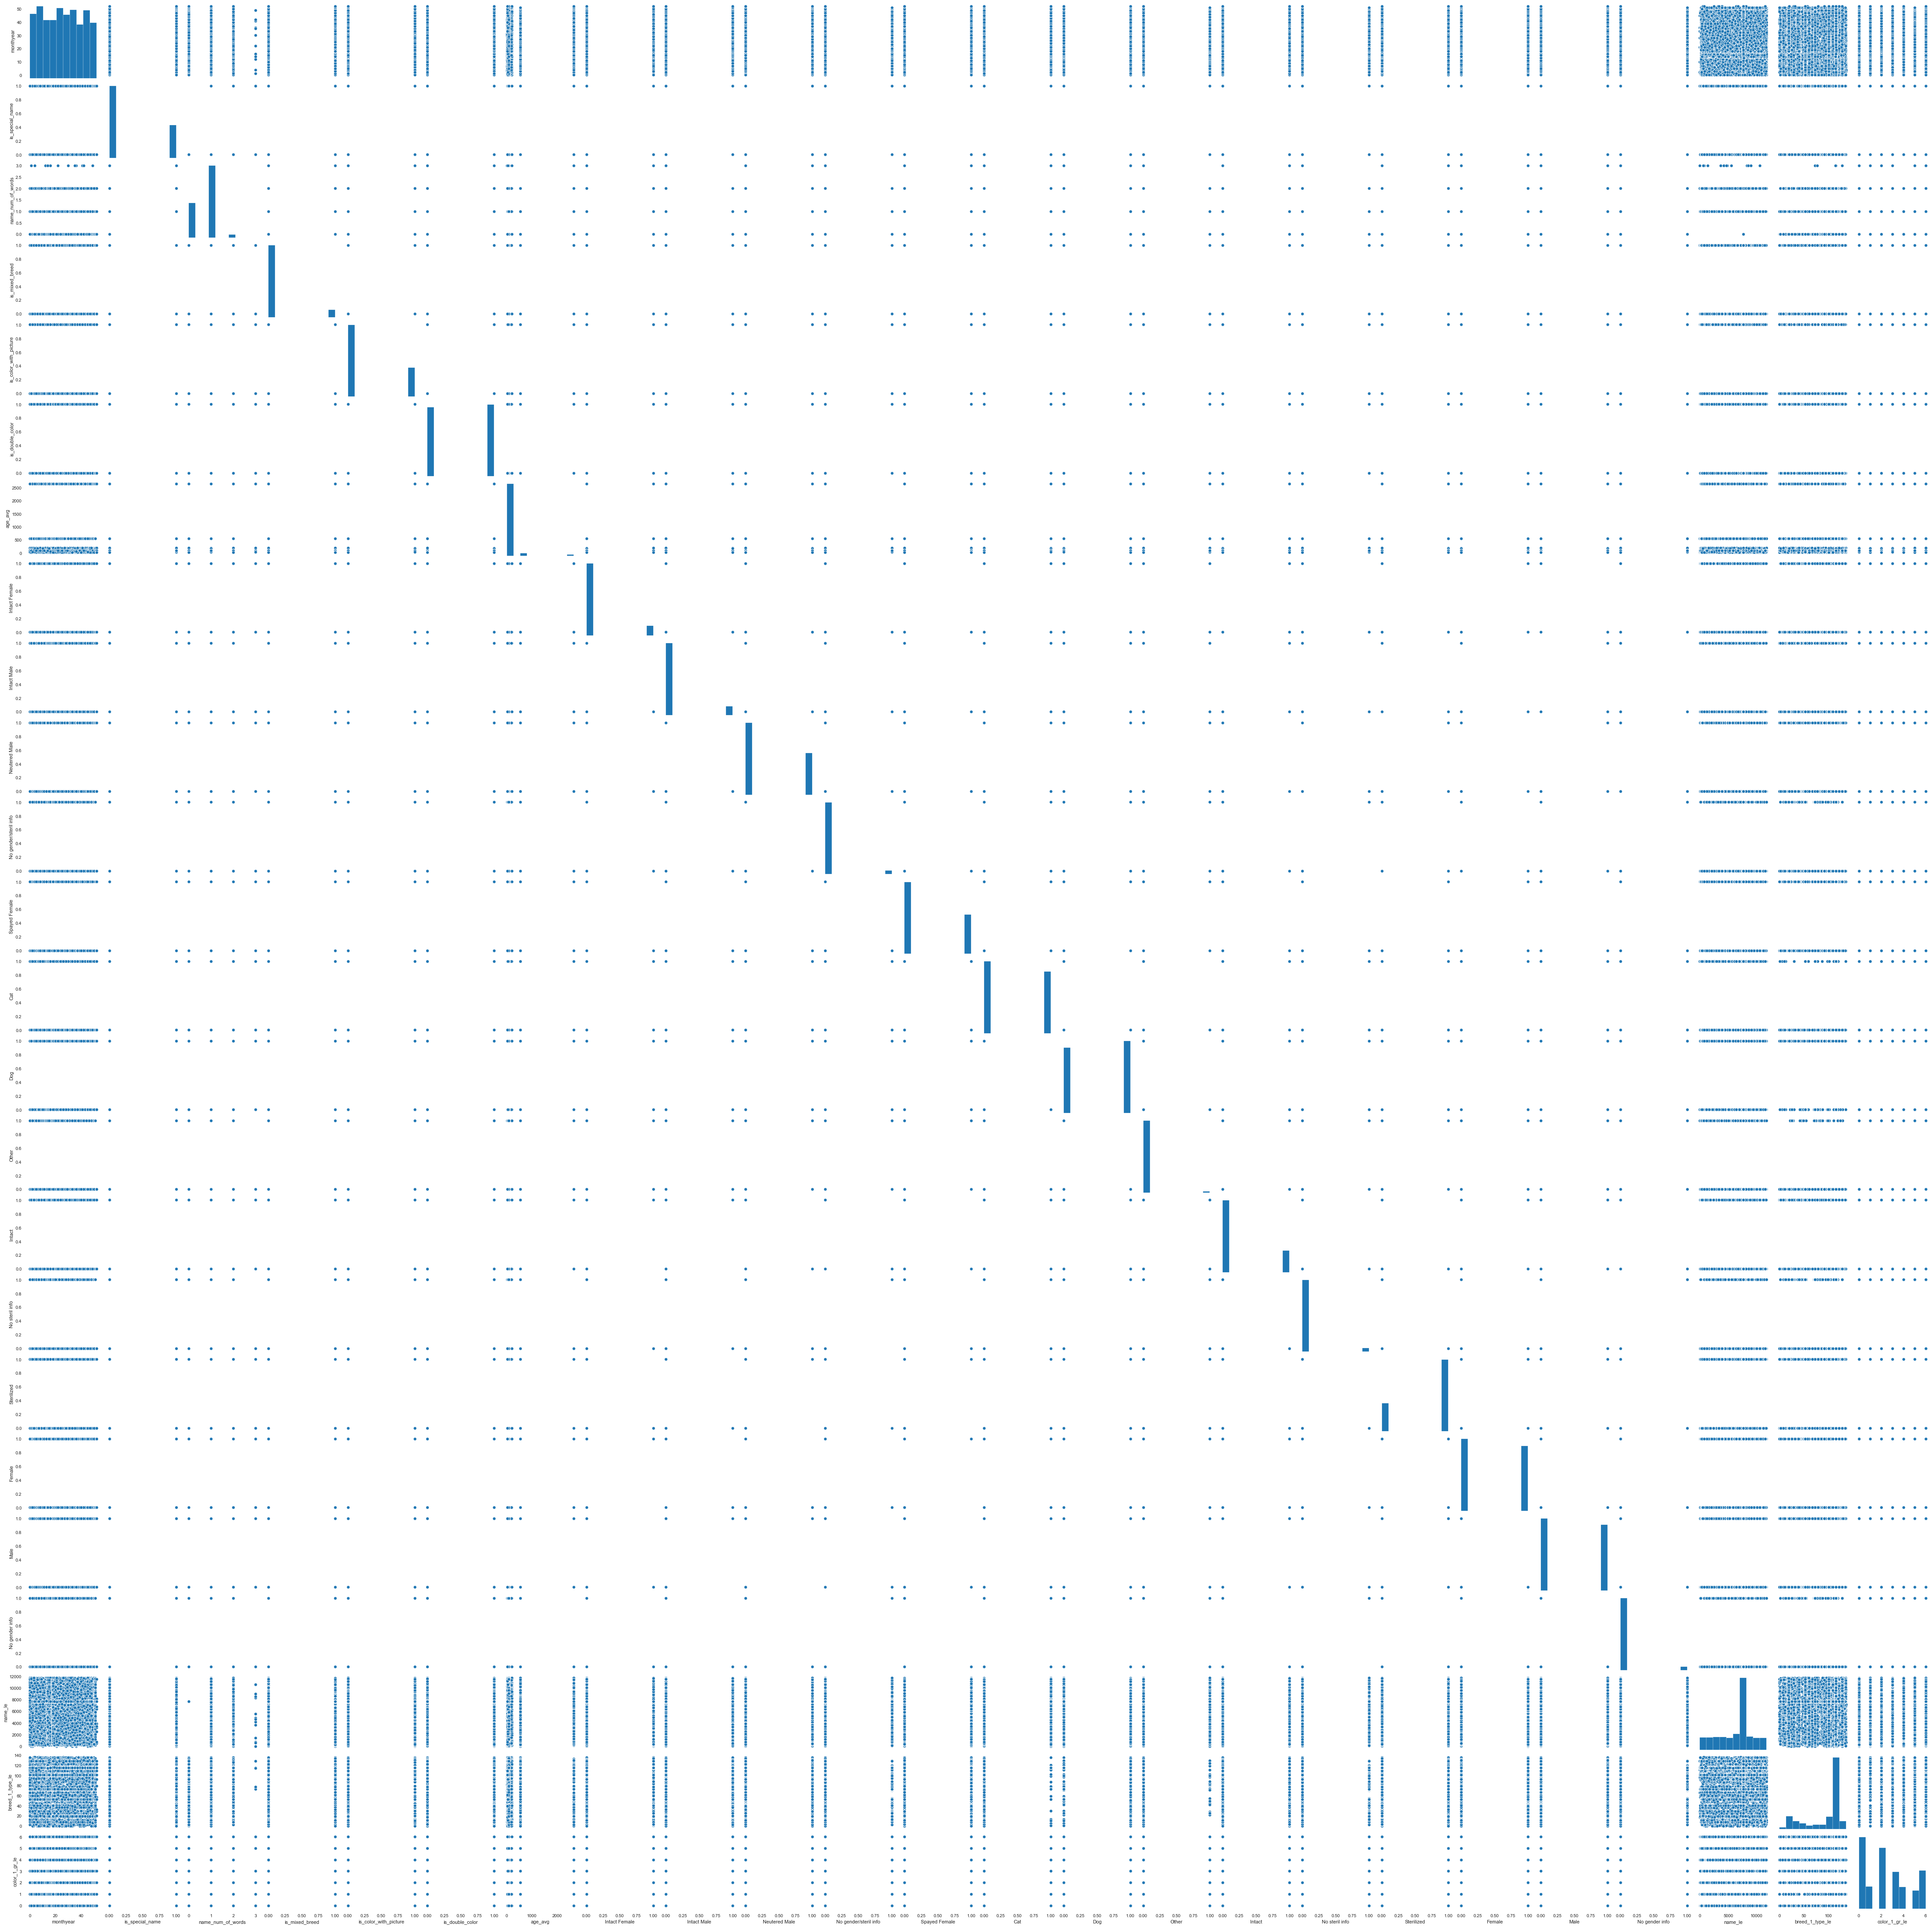

In [1409]:
sns.pairplot(data)

In [598]:
dig_columns = ['is_special_name', 'name_num_of_words', 'is_mixed_breed',
       'is_one_color', 'Intact Female', 'Intact Male', 'Neutered Male',
       'No gender/steril info', 'Spayed Female', 'Bird', 'Cat', 'Dog',
       'Livestock', 'Other', 'Intact', 'name_le', 'breed_1_type_le',
       'age_avg']

In [599]:
X = data_combine_ster_gender.drop(['outcome_type'], axis=1)
y = data_combine_ster_gender.outcome_type
stand_scaler = StandardScaler()
X_cat = X.monthyear
X_dig = pd.DataFrame(stand_scaler.fit_transform(X[dig_columns]), columns=dig_columns)
X_dig.head()

,is_special_name,name_num_of_words,is_mixed_breed,is_one_color,Intact Female,Intact Male,Neutered Male,No gender/steril info,Spayed Female,Bird,Cat,Dog,Livestock,Other,Intact,name_le,breed_1_type_le,age_avg
0,-0.558772,-1.422790,-0.318979,-0.702898,-0.363859,2.684800,-0.742784,-0.300819,-0.690279,-0.056047,1.285604,-1.143793,-0.009479,-0.236670,1.785657,0.432093,0.707919,-0.355924
1,-0.558772,0.541556,-0.318979,-0.702898,-0.363859,-0.372467,-0.742784,-0.300819,1.448690,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,-0.026563,-2.010722,-0.283623
2,1.789638,0.541556,-0.318979,-0.702898,-0.363859,-0.372467,1.346287,-0.300819,-0.690279,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,-0.429834,-1.731236,-0.187222
3,-0.558772,0.541556,-0.318979,1.422682,-0.363859,-0.372467,1.346287,-0.300819,-0.690279,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,0.263515,0.555472,0.816225
4,-0.558772,-1.422790,-0.318979,1.422682,-0.363859,-0.372467,-0.742784,3.324263,-0.690279,-0.056047,-0.777845,-1.143793,-0.009479,4.225297,-0.560018,0.432093,-2.036130,-0.290196


In [600]:
# X = pd.concat([X_cat, X_dig], axis=1)
X = pd.DataFrame(X_dig)

In [601]:
X.describe()

,is_special_name,name_num_of_words,is_mixed_breed,is_one_color,Intact Female,Intact Male,Neutered Male,No gender/steril info,Spayed Female,Bird,Cat,Dog,Livestock,Other,Intact,name_le,breed_1_type_le,age_avg
count,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04,7.792000e+04
mean,-1.221148e-14,7.866340e-16,-4.956989e-14,-2.660541e-15,8.994920e-15,1.763831e-15,-7.359588e-16,-1.641788e-14,1.989445e-15,8.679585e-15,-1.161202e-14,-3.496197e-15,-5.825977e-15,-3.704241e-15,1.641908e-15,-6.512943e-16,-8.096564e-16,4.958189e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-5.587722e-01,-1.422790e+00,-3.189791e-01,-7.028980e-01,-3.638592e-01,-3.724672e-01,-7.427837e-01,-3.008185e-01,-6.902787e-01,-5.604689e-02,-7.778448e-01,-1.143793e+00,-9.478597e-03,-2.366698e-01,-5.600179e-01,-2.219458e+00,-2.213985e+00,-3.559241e-01
25%,-5.587722e-01,-1.422790e+00,-3.189791e-01,-7.028980e-01,-3.638592e-01,-3.724672e-01,-7.427837e-01,-3.008185e-01,-6.902787e-01,-5.604689e-02,-7.778448e-01,-1.143793e+00,-9.478597e-03,-2.366698e-01,-5.600179e-01,-7.341912e-01,-8.673685e-01,-2.901961e-01
50%,-5.587722e-01,5.415565e-01,-3.189791e-01,-7.028980e-01,-3.638592e-01,-3.724672e-01,-7.427837e-01,-3.008185e-01,-6.902787e-01,-5.604689e-02,-7.778448e-01,8.742842e-01,-9.478597e-03,-2.366698e-01,-5.600179e-01,4.320931e-01,6.825113e-01,-1.894132e-01
75%,-5.587722e-01,5.415565e-01,-3.189791e-01,1.422682e+00,-3.638592e-01,-3.724672e-01,1.346287e+00,-3.008185e-01,1.448690e+00,-5.604689e-02,1.285604e+00,8.742842e-01,-9.478597e-03,-2.366698e-01,-5.600179e-01,4.320931e-01,7.079191e-01,-1.872223e-01
max,1.789638e+00,6.434595e+00,3.135002e+00,1.422682e+00,2.748316e+00,2.684800e+00,1.346287e+00,3.324263e+00,1.448690e+00,1.784220e+01,1.285604e+00,8.742842e-01,1.055008e+02,4.225297e+00,1.785657e+00,1.848907e+00,1.241484e+00,5.417184e+00


In [602]:
# y = le.fit_transform(y)
# y = pd.factorize(data_combine_ster_gender.outcome_type)[0]

In [603]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [604]:
y_train = pd.factorize(y_train)[0]

In [605]:
X_train.shape, X_test.shape

((58440, 18), (19480, 18))

In [606]:
from sklearn.ensemble import RandomForestClassifier

In [607]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
train_predict = rfc.predict(X_train)
test_predict = rfc.predict(X_test)

print(f'Train MAE: {mean_absolute_error(train_predict, y_train)}')
# print(f'Test MAE: {mean_absolute_error(test_predict, y_test)}')

Train MAE: 0.12932922655715265


In [608]:
rfc.predict_proba(X_test)

array([[0.5       , 0.        , 0.01      , ..., 0.        , 0.        ,
        0.        ],
       [0.03      , 0.34      , 0.09      , ..., 0.        , 0.        ,
        0.        ],
       [0.6       , 0.15      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.23333333, 0.4       , 0.01      , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.96222789, 0.02355685, ..., 0.        , 0.        ,
        0.        ],
       [0.03333333, 0.4545    , 0.00666667, ..., 0.        , 0.        ,
        0.        ]])

In [609]:
preds = data_combine_ster_gender.outcome_type[rfc.predict(X_test)]

In [610]:
d = dict()
for x,y in zip(rfc.feature_importances_, X.columns):
    d[y] = x
res_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
res_df.columns = ['attr', 'coef']
res_df['abs_coef'] = np.abs(res_df.coef)
res_df.sort_values('abs_coef', ascending=False)

,attr,coef,abs_coef
15,name_le,0.358079,0.358079
17,age_avg,0.148813,0.148813
16,breed_1_type_le,0.136236,0.136236
14,Intact,0.069281,0.069281
1,name_num_of_words,0.056054,0.056054
0,is_special_name,0.050878,0.050878
7,No gender/steril info,0.038185,0.038185
13,Other,0.028463,0.028463
10,Cat,0.020655,0.020655
11,Dog,0.019443,0.019443


In [611]:
# df = pd.DataFrame()
# df['y_test'] = y_test
# df['preds'] = preds
preds

0    Transfer
3    Transfer
0    Transfer
1    Transfer
2    Adoption
       ...   
0    Transfer
0    Transfer
1    Transfer
1    Transfer
3    Transfer
Name: outcome_type, Length: 19480, dtype: object

In [612]:
df = pd.DataFrame(list(zip(y_test, preds)))
df.columns = ['y_test', 'preds']
df['diff_test'] = df.apply(lambda x: 0 if x['y_test'] == x['preds'] else 1, axis=1)

In [613]:
df.diff_test.sum()/len(df)

0.7016427104722792

### Так себе результат, попробуем с другим датасетом

In [523]:
data_split_ster_gender.columns

Index(['monthyear', 'outcome_type', 'is_special_name', 'name_num_of_words',
       'is_mixed_breed', 'is_one_color', 'Bird', 'Cat', 'Dog', 'Livestock',
       'Other', 'Intact', 'No steril info', 'Sterilized', 'Female', 'Male',
       'No gender info', 'name_le', 'breed_1_type_le', 'age_avg'],
      dtype='object')

In [539]:
dig_columns = ['is_special_name', 'name_num_of_words',
       'is_mixed_breed', 'is_one_color', 'Bird', 'Cat', 'Dog', 'Livestock',
       'Other', 'Intact', 'Sterilized', 'Female', 'Male',
       'No gender info', 'name_le', 'breed_1_type_le', 'age_avg']

In [540]:
X = data_split_ster_gender.drop(['outcome_type'], axis=1)
y = data_split_ster_gender.outcome_type
stand_scaler = StandardScaler()
X_cat = X.monthyear
X_dig = pd.DataFrame(stand_scaler.fit_transform(X[dig_columns]), columns=dig_columns)
X_dig.head()

,is_special_name,name_num_of_words,is_mixed_breed,is_one_color,Bird,Cat,Dog,Livestock,Other,Intact,Sterilized,Female,Male,No gender info,name_le,breed_1_type_le,age_avg
0,-0.558772,-1.422790,-0.318979,-0.702898,-0.056047,1.285604,-1.143793,-0.009479,-0.236670,1.785657,-1.451972,-0.885741,1.046296,-0.300819,0.432093,0.707919,-0.355924
1,-0.558772,0.541556,-0.318979,-0.702898,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,0.688719,1.128999,-0.955752,-0.300819,-0.026563,-2.010722,-0.283623
2,1.789638,0.541556,-0.318979,-0.702898,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,0.688719,-0.885741,1.046296,-0.300819,-0.429834,-1.731236,-0.187222
3,-0.558772,0.541556,-0.318979,1.422682,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,0.688719,-0.885741,1.046296,-0.300819,0.263515,0.555472,0.816225
4,-0.558772,-1.422790,-0.318979,1.422682,-0.056047,-0.777845,-1.143793,-0.009479,4.225297,-0.560018,-1.451972,-0.885741,-0.955752,3.324263,0.432093,-2.036130,-0.290196


In [541]:
# X = pd.concat([X_cat, X_dig], axis=1)
X = pd.DataFrame(X_dig)

In [542]:
# X.describe()

In [543]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [544]:
y_train = pd.factorize(y_train)[0]

In [545]:
X_train.shape, X_test.shape

((58440, 17), (19480, 17))

In [546]:
from sklearn.ensemble import RandomForestClassifier

In [547]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
train_predict = rfc.predict(X_train)
test_predict = rfc.predict(X_test)

print(f'Train MAE: {mean_absolute_error(train_predict, y_train)}')
# print(f'Test MAE: {mean_absolute_error(test_predict, y_test)}')

Train MAE: 0.14869952087611224


In [548]:
# rfc.predict_proba(X_test)

In [549]:
preds = data_combine_ster_gender.outcome_type[rfc.predict(X_test)]

In [550]:
d = dict()
for x,y in zip(rfc.feature_importances_, X.columns):
    d[y] = x
res_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
res_df.columns = ['attr', 'coef']
res_df['abs_coef'] = np.abs(res_df.coef)
res_df.sort_values('abs_coef', ascending=False)

,attr,coef,abs_coef
14,name_le,0.360128,0.360128
16,age_avg,0.140601,0.140601
15,breed_1_type_le,0.137924,0.137924
10,Sterilized,0.094790,0.094790
1,name_num_of_words,0.055830,0.055830
0,is_special_name,0.050512,0.050512
9,Intact,0.048596,0.048596
8,Other,0.027557,0.027557
13,No gender info,0.020354,0.020354
5,Cat,0.020335,0.020335


In [551]:
df = pd.DataFrame(list(zip(y_test, preds)))
df.columns = ['y_test', 'preds']
df['diff_test'] = df.apply(lambda x: 0 if x['y_test'] == x['preds'] else 1, axis=1)

In [552]:
df.diff_test.sum()/len(df)

0.6788501026694045

### Со вторым датасетом намного хуже, поэтому будем работать с первым - data_combine_ster_gender

In [553]:
data_combine_ster_gender.columns

Index(['monthyear', 'outcome_type', 'is_special_name', 'name_num_of_words',
       'is_mixed_breed', 'is_one_color', 'Intact Female', 'Intact Male',
       'Neutered Male', 'No gender/steril info', 'Spayed Female', 'Bird',
       'Cat', 'Dog', 'Livestock', 'Other', 'Intact', 'name_le',
       'breed_1_type_le', 'age_avg'],
      dtype='object')

In [554]:
dig_columns = ['is_special_name', 'name_num_of_words', 'is_mixed_breed',
       'is_one_color', 'Intact Female', 'Intact Male', 'Neutered Male',
       'No gender/steril info', 'Spayed Female', 'Bird', 'Cat', 'Dog',
       'Livestock', 'Other', 'Intact', 'breed_1_type_le',
       'age_avg']

In [555]:
X = data_combine_ster_gender.drop(['outcome_type'], axis=1)
y = data_combine_ster_gender.outcome_type
stand_scaler = StandardScaler()
X_cat = X.monthyear
X_dig = pd.DataFrame(stand_scaler.fit_transform(X[dig_columns]), columns=dig_columns)
X_dig.head()

,is_special_name,name_num_of_words,is_mixed_breed,is_one_color,Intact Female,Intact Male,Neutered Male,No gender/steril info,Spayed Female,Bird,Cat,Dog,Livestock,Other,Intact,breed_1_type_le,age_avg
0,-0.558772,-1.422790,-0.318979,-0.702898,-0.363859,2.684800,-0.742784,-0.300819,-0.690279,-0.056047,1.285604,-1.143793,-0.009479,-0.236670,1.785657,0.707919,-0.355924
1,-0.558772,0.541556,-0.318979,-0.702898,-0.363859,-0.372467,-0.742784,-0.300819,1.448690,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,-2.010722,-0.283623
2,1.789638,0.541556,-0.318979,-0.702898,-0.363859,-0.372467,1.346287,-0.300819,-0.690279,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,-1.731236,-0.187222
3,-0.558772,0.541556,-0.318979,1.422682,-0.363859,-0.372467,1.346287,-0.300819,-0.690279,-0.056047,-0.777845,0.874284,-0.009479,-0.236670,-0.560018,0.555472,0.816225
4,-0.558772,-1.422790,-0.318979,1.422682,-0.363859,-0.372467,-0.742784,3.324263,-0.690279,-0.056047,-0.777845,-1.143793,-0.009479,4.225297,-0.560018,-2.036130,-0.290196


In [556]:
# X = pd.concat([X_cat, X_dig], axis=1)
X = pd.DataFrame(X_dig)

In [557]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [558]:
y_train = pd.factorize(y_train)[0]

In [559]:
X_train.shape, X_test.shape

((58440, 17), (19480, 17))

In [560]:
from sklearn.ensemble import RandomForestClassifier

In [561]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
train_predict = rfc.predict(X_train)
test_predict = rfc.predict(X_test)

print(f'Train MAE: {mean_absolute_error(train_predict, y_train)}')
# print(f'Test MAE: {mean_absolute_error(test_predict, y_test)}')

Train MAE: 0.4787303216974675


In [562]:
preds = data_combine_ster_gender.outcome_type[rfc.predict(X_test)]

In [563]:
d = dict()
for x,y in zip(rfc.feature_importances_, X.columns):
    d[y] = x
res_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
res_df.columns = ['attr', 'coef']
res_df['abs_coef'] = np.abs(res_df.coef)
res_df.sort_values('abs_coef', ascending=False)

,attr,coef,abs_coef
16,age_avg,0.227421,0.227421
15,breed_1_type_le,0.212581,0.212581
14,Intact,0.111752,0.111752
1,name_num_of_words,0.098365,0.098365
0,is_special_name,0.080730,0.080730
13,Other,0.052795,0.052795
7,No gender/steril info,0.049229,0.049229
10,Cat,0.028360,0.028360
11,Dog,0.028342,0.028342
4,Intact Female,0.023715,0.023715


In [564]:
df = pd.DataFrame(list(zip(y_test, preds)))
df.columns = ['y_test', 'preds']
df['diff_test'] = df.apply(lambda x: 0 if x['y_test'] == x['preds'] else 1, axis=1)

In [565]:
df.diff_test.sum()/len(df)

0.7036447638603696

Без имен стало намного хуже - попробуем убирать флаги

In [1406]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
train_predict = lin_reg.predict(X_train)
test_predict = lin_reg.predict(X_test)

print(f'Train MAE: {mean_absolute_error(train_predict, y_train)}')
# print(f'Test MAE: {mean_absolute_error(test_predict, y_test)}')

Train MAE: 0.295134061559856


In [1407]:
d = dict()
for x,y in zip(lin_reg.coef_, X.columns):
    d[y] = x
res_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
res_df.columns = ['attr', 'coef']
res_df['abs_coef'] = np.abs(res_df.coef)
res_df.sort_values('abs_coef', ascending=False)

,attr,coef,abs_coef
0,Sterilized,-0.307025,0.307025
1,name_le,0.013205,0.013205
